## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1
from Distiller_beta import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


2022-05-13 15:53:48.302458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 15:53:48.302509: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [4]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits_datagen")
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================


2022-05-13 15:54:10.449335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-13 15:54:10.449392: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-13 15:54:10.449434: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (big25): /proc/driver/nvidia/version does not exist
2022-05-13 15:54:10.464035: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluation of Teacher model!
313/313 [==============================] - 13s 38ms/step - loss: 0.4362 - sparse_categorical_accuracy: 0.9084



## Creating a data augmentation process

In [5]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building callbacks

In [6]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)


## Knowledge distillation

In [7]:
BATCH_SIZE = 32
EPOCHS = 100
A = [ 0.8, 0.9]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 78s 48ms/step - sparse_categorical_accuracy: 0.3486 - student_loss: 1.7823 - loss: 2.3745 - val_sparse_categorical_accuracy: 0.4076 - val_student_loss: 3.4943 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 76s 47ms/step - sparse_categorical_accuracy: 0.4571 - student_loss: 1.5055 - loss: 2.0051 - val_sparse_categorical_accuracy: 0.5007 - val_student_loss: 1.5186 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 75s 46ms/step - sparse_categorical_accuracy: 0.5112 - student_loss: 1.3826 - loss: 1.8346 - val_sparse_categorical_accuracy: 0.4602 - val_student_loss: 2.6538 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 47ms/step - sparse_categorical_accuracy: 0.5413 - student_loss: 1.3056 - loss: 1.7268 - val_sparse_categorical_accuracy: 0.5293 - val_student_loss: 1.6835 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 75s 47ms/step - sparse_cate

Epoch 35/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7403 - student_loss: 0.7708 - loss: 0.9916
Epoch 35: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 88s 53ms/step - sparse_categorical_accuracy: 0.7403 - student_loss: 0.7708 - loss: 0.9915 - val_sparse_categorical_accuracy: 0.7297 - val_student_loss: 2.4969 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 89s 54ms/step - sparse_categorical_accuracy: 0.7423 - student_loss: 0.7606 - loss: 0.9796 - val_sparse_categorical_accuracy: 0.7310 - val_student_loss: 2.4962 - lr: 1.0000e-04
Epoch 37/100
1562/1562 [==============================] - 89s 54ms/step - sparse_categorical_accuracy: 0.7455 - student_loss: 0.7484 - loss: 0.9667 - val_sparse_categorical_accuracy: 0.7308 - val_student_loss: 2.4900 - lr: 1.0000e-04
Epoch 38/100
1562/1562 [==============================] - 91s 55ms/step - sparse_categorical

1562/1562 [==============================] - 92s 56ms/step - sparse_categorical_accuracy: 0.7419 - student_loss: 0.7582 - loss: 0.9778 - val_sparse_categorical_accuracy: 0.7307 - val_student_loss: 2.4923 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 87s 53ms/step - sparse_categorical_accuracy: 0.7439 - student_loss: 0.7560 - loss: 0.9746 - val_sparse_categorical_accuracy: 0.7297 - val_student_loss: 2.4866 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 92s 55ms/step - sparse_categorical_accuracy: 0.7421 - student_loss: 0.7574 - loss: 0.9753 - val_sparse_categorical_accuracy: 0.7317 - val_student_loss: 2.4917 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7428 - student_loss: 0.7543 - loss: 0.9731 - val_sparse_categorical_accuracy: 0.7323 - val_student_loss: 2.4845 - lr: 1.0000e-06
Epoch 71/100
1562/1562 [==============================] - 90s 55ms/step - spa

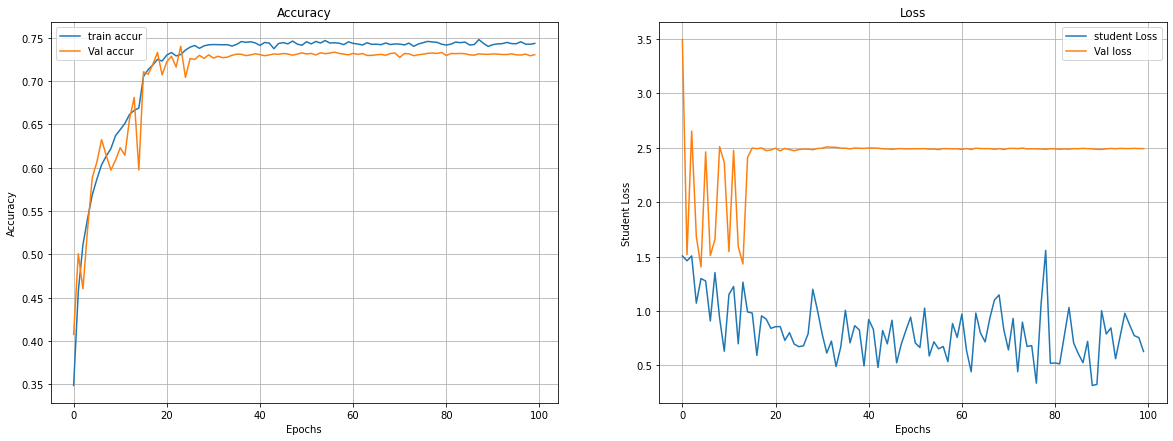

Saving model 


2022-05-13 18:22:18.170438: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.8/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 98s 57ms/step - sparse_categorical_accuracy: 0.3649 - student_loss: 1.7476 - loss: 2.3989 - val_sparse_categorical_accuracy: 0.4443 - val_student_loss: 3.5492 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 91s 54ms/step - sparse_categorical_accuracy: 0.4804 - student_loss: 1.4592 - loss: 1.9984 - val_sparse_categorical_accuracy: 0.5311 - val_student_loss: 2.5895 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.5310 - student_loss: 1.3349 - loss: 1.8196 - val_sparse_categorical_accuracy: 0.5191 - val_student_loss: 2.4683 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.5686 - student_loss: 1.2386 - loss: 1.6832 - val_sparse_categorical_accuracy: 0.6023 - v

1562/1562 [==============================] - 94s 56ms/step - sparse_categorical_accuracy: 0.7580 - student_loss: 0.7192 - loss: 0.9411 - val_sparse_categorical_accuracy: 0.7474 - val_student_loss: 2.4994 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 92s 55ms/step - sparse_categorical_accuracy: 0.7583 - student_loss: 0.7177 - loss: 0.9399 - val_sparse_categorical_accuracy: 0.7501 - val_student_loss: 2.4828 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 92s 55ms/step - sparse_categorical_accuracy: 0.7597 - student_loss: 0.7103 - loss: 0.9325 - val_sparse_categorical_accuracy: 0.7470 - val_student_loss: 2.5012 - lr: 1.0000e-03
Epoch 37/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7646 - student_loss: 0.7006 - loss: 0.9227
Epoch 37: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 93s 55ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7602 - student_loss: 0.7066 - loss: 0.9263 - val_sparse_categorical_accuracy: 0.7495 - val_student_loss: 2.4965 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 96s 57ms/step - sparse_categorical_accuracy: 0.7654 - student_loss: 0.7048 - loss: 0.9264 - val_sparse_categorical_accuracy: 0.7499 - val_student_loss: 2.5117 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 93s 55ms/step - sparse_categorical_accuracy: 0.7584 - student_loss: 0.7070 - loss: 0.9275 - val_sparse_categorical_accuracy: 0.7500 - val_student_loss: 2.4941 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 90s 54ms/step - sparse_categorical_accuracy: 0.7622 - student_loss: 0.7007 - loss: 0.9219 - val_sparse_categorical_accuracy: 0.7491 - val_student_loss: 2.4943 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 92s 55ms/step - spa

313/313 [==============================] - 3s 11ms/step - sparse_categorical_accuracy: 0.7468 - student_loss: 1.7196

 =============== History Plot ===============


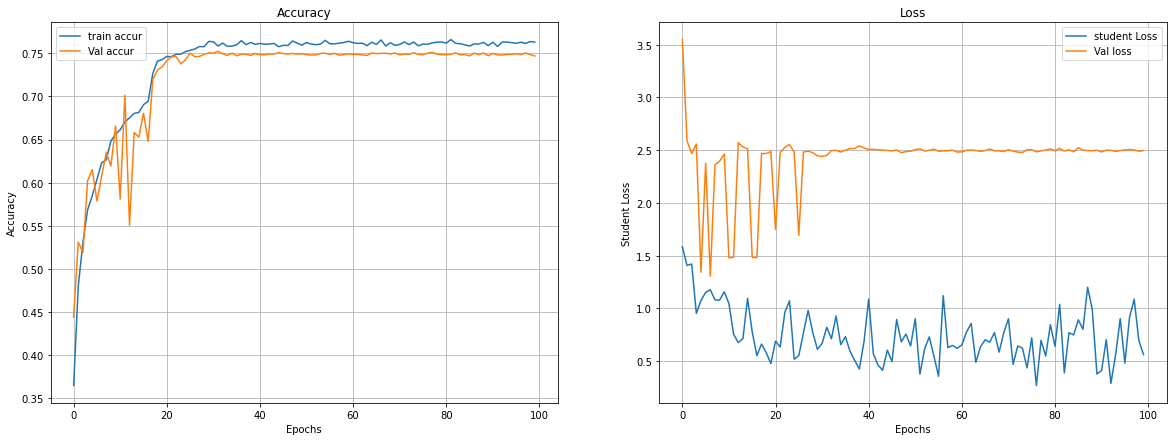

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.9/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [8]:
for a in A:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_beta_{a}_temp5"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)
    
    student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

    dist = Distiller(teacher, student)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = a,
        temperature = 5)

    # Train and evaluate on data.
    hist = dist.fit(datagen.flow(x_train, y_train, 
          batch_size = BATCH_SIZE),
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =64,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_KD_notebook_beta{a}.png")


    print("Saving model ")
    student.save(f"Resnet8_KD_notebook_beta{a}")
    print("Saving Done !")

    print("Saving Weights ")
    student.save_weights(f"w_resnet8_beta_{a}.h5")
    print("Saving Done !")
    print("")

    print("End !")